# 1 Importing libraries.

In [6]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/movielens-20m-dataset/rating.csv
/kaggle/input/movielens-20m-dataset/link.csv
/kaggle/input/movielens-20m-dataset/genome_tags.csv
/kaggle/input/movielens-20m-dataset/genome_scores.csv
/kaggle/input/movielens-20m-dataset/tag.csv
/kaggle/input/movielens-20m-dataset/movie.csv


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
import random as rd


from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import warnings
import random
import pickle
from tqdm import tqdm

warnings.filterwarnings('ignore')

In [8]:
# # for connecting to google drive
# from google.colab import drive
# drive.mount('/content/drive')

# from google.colab import files

# path = "/content/drive/MyDrive/Colab Notebooks/data/movielens_recom/"

In [9]:
!pip install catboost

# 2 Exploratory data analysis.

## 2.1 Upload the dataset with information about films.


In [10]:
movies_data = pd.read_csv("/kaggle/input/movielens-20m-dataset/movie.csv")
# movies_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/movielens_recom/movie.csv")
print("The size of dataset is", movies_data.shape)
movies_data.head()

The size of dataset is (27278, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
movies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB


**Let's extract the year from the "title"**

In [12]:
movies_data["year_shot"] = movies_data["title"].apply(lambda x: "".join(re.findall(r"\((\d+)\)+$", x)))
movies_data.head()

,movieId,title,genres,year_shot
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [13]:
movies_data.isnull().sum()

movieId      0
title        0
genres       0
year_shot    0
dtype: int64

In [14]:
# Let's have a look at the unique years. We see that some films don't have the year
movies_data["year_shot"].unique()

array(['1995', '1994', '1996', '1976', '1992', '1988', '1967', '1993',
       '1964', '1977', '1965', '1982', '1985', '1990', '1991', '1989',
       '1937', '1940', '1969', '1981', '1973', '1970', '1960', '1955',
       '1959', '1968', '1980', '1975', '1986', '1948', '1943', '1950',
       '1946', '1987', '1997', '1974', '1956', '1958', '1949', '1972',
       '1998', '1933', '1952', '1951', '1957', '1961', '1954', '1934',
       '1944', '1963', '1942', '1941', '1953', '1939', '1947', '1945',
       '1938', '1935', '1936', '1926', '1932', '1979', '1971', '1978',
       '1966', '1962', '1983', '1984', '1931', '1922', '1999', '1927',
       '1929', '1930', '1928', '1925', '1914', '2000', '1919', '1923',
       '1920', '1918', '1921', '2001', '1924', '2002', '2003', '1915',
       '2004', '1916', '', '1917', '2005', '2006', '1902', '1903', '2007',
       '2008', '2009', '1912', '2010', '1913', '2011', '1898', '1899',
       '1894', '2012', '1909', '1910', '1901', '1893', '2013', '1896',
  

In [15]:
movies_data[movies_data["year_shot"] == ""]
print("-------")
print("The number with blanks in 'year' -", len(movies_data[movies_data["year_shot"] == ""]))

-------
The number with blanks in 'year' - 51


In [16]:
mask = movies_data["year_shot"] == ""
movies_data.loc[mask, "year_shot"] = movies_data[mask]["title"].apply(lambda x: "".join(re.findall(r"\((\d+)\)", x)))

In [17]:
movies_data[movies_data["year_shot"] == ""]
print("-------")
print("The number with blanks in 'year' -", len(movies_data[movies_data["year_shot"] == ""]))

-------
The number with blanks in 'year' - 22


In [18]:
movies_data.loc[movies_data["year_shot"] == "", "year_shot"] = np.nan

In [19]:
movies_data[movies_data["year_shot"].isna()]

,movieId,title,genres,year_shot
10593,40697,Babylon 5,Sci-Fi,NaN
15646,79607,"Millions Game, The (Das Millionenspiel)",Action|Drama|Sci-Fi|Thriller,NaN
17341,87442,"Bicycle, Spoon, Apple (Bicicleta, cullera, poma)",Documentary,NaN
22368,107434,Diplomatic Immunity (2009– ),Comedy,NaN
22669,108548,"Big Bang Theory, The (2007-)",Comedy,NaN
22679,108583,Fawlty Towers (1975-1979),Comedy,NaN
23617,112406,Brazil: In the Shadow of the Stadiums,Documentary,NaN
23824,113190,Slaying the Badger,Documentary,NaN
24286,115133,Tatort: Im Schmerz geboren,Crime,NaN
24412,115685,National Theatre Live: Frankenstein,Drama|Fantasy,NaN


**We see that there are some blanks in "year". I'll delete these rows as their amount is not huge.**

In [20]:
# convert "year" to numeric
mask1 = (~movies_data["year_shot"].isna())
movies_data.loc[mask1, "year_shot"] = movies_data.loc[mask1, "year_shot"].astype(int)

year_shot
1891    AxesSubplot(0.125,0.125;0.775x0.755)
1893    AxesSubplot(0.125,0.125;0.775x0.755)
1894    AxesSubplot(0.125,0.125;0.775x0.755)
1895    AxesSubplot(0.125,0.125;0.775x0.755)
1896    AxesSubplot(0.125,0.125;0.775x0.755)
                        ...                 
2011    AxesSubplot(0.125,0.125;0.775x0.755)
2012    AxesSubplot(0.125,0.125;0.775x0.755)
2013    AxesSubplot(0.125,0.125;0.775x0.755)
2014    AxesSubplot(0.125,0.125;0.775x0.755)
2015    AxesSubplot(0.125,0.125;0.775x0.755)
Name: year_shot, Length: 118, dtype: object

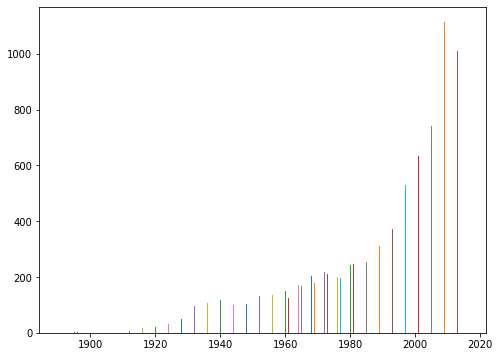

In [21]:
movies_data.groupby("year_shot")["year_shot"].hist(grid=False ,figsize=(8, 6))

In [22]:
movies_data.head()

,movieId,title,genres,year_shot
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [23]:
movies_data.groupby("year_shot")["movieId"].count()

year_shot
1891       1
1893       1
1894       2
1895       2
1896       2
        ... 
2011    1016
2012    1022
2013    1011
2014     740
2015     120
Name: movieId, Length: 118, dtype: int64

## 2.2 Upload the dataset with information about ratings


In [24]:
ratings_data = pd.read_csv("/kaggle/input/movielens-20m-dataset/rating.csv")
# ratings_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/movielens_recom/rating.csv")
print("The size of dataset is", ratings_data.shape)
ratings_data.head()

The size of dataset is (20000263, 4)


,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [25]:
ratings_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB


In [26]:
ratings_data.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [27]:
# Let's have a look at the unique number of users
ratings_data[["userId"]].nunique() 

userId    138493
dtype: int64

**Before we begin to do manipulation with this dataset I cut some users in order to do calculations faster**

In [28]:
random.seed(0)
special_users = random.sample(list(ratings_data["userId"]), 800)
print(len(special_users))

800


In [29]:
special_ratings_data = ratings_data[ratings_data["userId"].isin(special_users)]
print(special_ratings_data.shape)
special_ratings_data.head()

(398976, 4)


,userId,movieId,rating,timestamp
2302,22,1,3.0,2001-07-09 00:22:37
2303,22,6,5.0,2001-07-09 00:29:33
2304,22,16,5.0,2001-07-09 00:23:48
2305,22,47,4.0,2001-07-09 00:21:17
2306,22,50,4.0,2001-07-09 00:19:39


In [30]:
# convert time to more convenient format
special_ratings_data["date"] =  pd.to_datetime(special_ratings_data.timestamp).dt.date # переведем Unix время в удобный для нас формат
special_ratings_data.head()

,userId,movieId,rating,timestamp,date
2302,22,1,3.0,2001-07-09 00:22:37,2001-07-09
2303,22,6,5.0,2001-07-09 00:29:33,2001-07-09
2304,22,16,5.0,2001-07-09 00:23:48,2001-07-09
2305,22,47,4.0,2001-07-09 00:21:17,2001-07-09
2306,22,50,4.0,2001-07-09 00:19:39,2001-07-09


<AxesSubplot:>

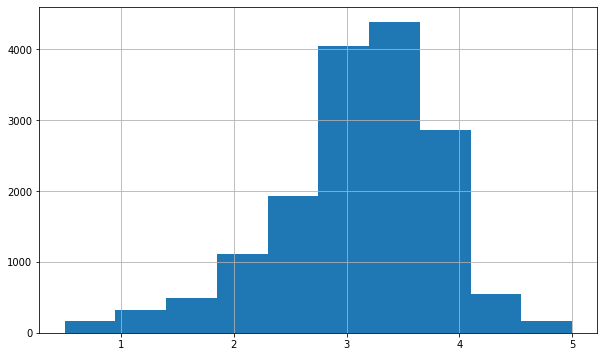

In [31]:
# distribution of mean rating
special_ratings_data.groupby("movieId").rating.mean().hist(figsize=(10, 6)) 

Total number of people 790
People with 2 or more unique days 557


Text(0, 0.5, 'Number of users')

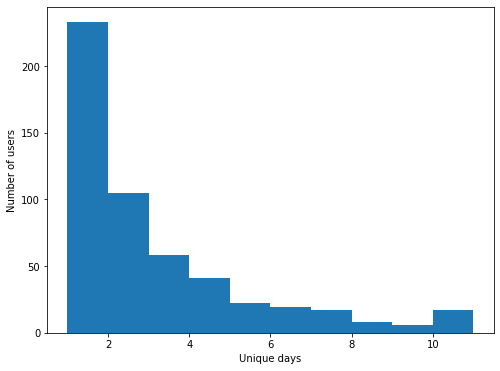

In [32]:
# let's see how many unique days each person watched movies
unique_days = special_ratings_data[["userId", "date"]].groupby("userId")["date"].nunique().to_frame()
print("Total number of people", len(unique_days))
print("People with 2 or more unique days", len(unique_days[unique_days["date"] > 1]))
special_ratings_data[["userId", "date"]].groupby("userId")["date"].nunique().hist(grid=False, bins=range(1, 12), figsize=(8, 6))

plt.xlabel("Unique days")
plt.ylabel("Number of users")

In [33]:
# let's see how many films are watched by a user in one day
special_ratings_data[["userId", "date", "movieId"]].groupby(["userId", "date"])["movieId"].nunique()


userId  date      
22      2001-07-09    133
72      2007-12-31     84
77      2012-07-04    100
295     1997-05-18    324
377     1997-05-24    199
                     ... 
138325  2012-09-05     43
        2012-09-07     18
        2012-10-15     59
        2012-10-16     22
        2012-11-09     20
Name: movieId, Length: 35745, dtype: int64

**We see that the person with id=22 wathced 133 movies in one day. It's impossible. So I don't know what the column "timestamp" actually means. Maybe it tells us about days when ratings were set? I don't know**

# 3 Feature engineering.

In [34]:
special_ratings_data.drop("timestamp", axis=1, inplace=True)
special_ratings_data.head()

,userId,movieId,rating,date
2302,22,1,3.0,2001-07-09
2303,22,6,5.0,2001-07-09
2304,22,16,5.0,2001-07-09
2305,22,47,4.0,2001-07-09
2306,22,50,4.0,2001-07-09


In [35]:
# delete those films where we have Nan in the "year"
special_ratings_data = special_ratings_data[~(special_ratings_data["movieId"].isin(movies_data[movies_data["year_shot"].isna()]["movieId"]))]
print(special_ratings_data.shape)
special_ratings_data.head()

(398962, 4)


,userId,movieId,rating,date
2302,22,1,3.0,2001-07-09
2303,22,6,5.0,2001-07-09
2304,22,16,5.0,2001-07-09
2305,22,47,4.0,2001-07-09
2306,22,50,4.0,2001-07-09


In [36]:
movies_data = movies_data[~(movies_data["year_shot"].isna())]
print(movies_data.shape)
movies_data.head()

(27256, 4)


,movieId,title,genres,year_shot
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


**As we have big range in years when the films were shot I suggest to split the time to the periods. We do that by using clustering**

In [37]:
# %%time
# special_ratings_data["year_shot"] = special_ratings_data['movieId'].map(movies_data.set_index("movieId")['year_shot'])
# special_ratings_data.head()

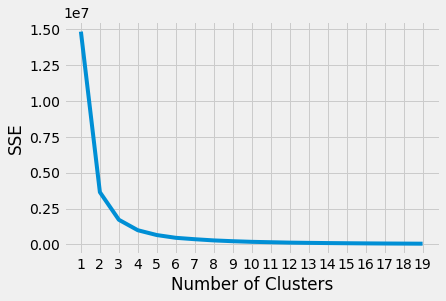

CPU times: user 7.05 s, sys: 234 ms, total: 7.28 s
Wall time: 4.21 s


In [38]:
%%time
from sklearn.cluster import KMeans

sse = []
for i in range(1,20):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(movies_data[["year_shot"]])
    sse.append(kmeans.inertia_) # inetria returns the sum of squared distances between each sample and the nearest centroid
    

plt.style.use("fivethirtyeight")
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [39]:
n_clust_year = 11

In [40]:
kmeans_best_model = KMeans(n_clusters=n_clust_year, random_state=0)
kmeans_best_model.fit(movies_data[["year_shot"]])

KMeans(n_clusters=11, random_state=0)

In [41]:
movies_data["kmeans_labels"] = kmeans_best_model.labels_
movies_data.rename(columns={"kmeans_labels": "period"}, inplace=True)
movies_data.head()

,movieId,title,genres,year_shot,period
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,0
4,5,Father of the Bride Part II (1995),Comedy,1995,0


Text(0.5, 1.0, 'The amount of films by periods')

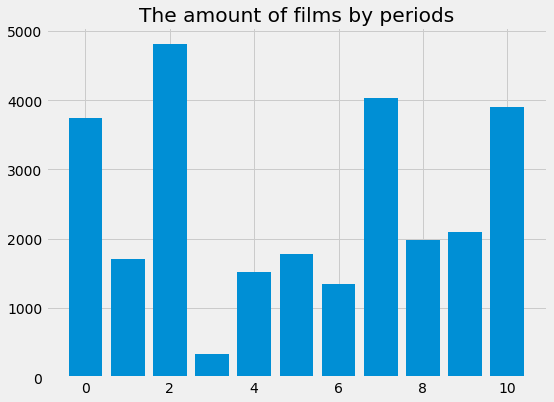

In [42]:
periods = movies_data.groupby("period", as_index=False).movieId.nunique()

fig = plt.figure(figsize=(8, 6))
plt.bar(periods["period"], periods["movieId"])
plt.title("The amount of films by periods")

In [43]:
np.sort(movies_data["year_shot"].unique())

array([1891, 1893, 1894, 1895, 1896, 1898, 1899, 1900, 1901, 1902, 1903,
       1905, 1909, 1910, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919,
       1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930,
       1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941,
       1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952,
       1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963,
       1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974,
       1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015], dtype=object)

**Split the "genre" column in movies_data dataset**

In [44]:
movies_data["genres_list"] = movies_data["genres"].str.split("|")
movies_data.head()

,movieId,title,genres,year_shot,period,genres_list
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,0,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,0,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,0,"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,0,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),Comedy,1995,0,[Comedy]


In [45]:
# convert the "genres_list columns" to pd.Series in order to extract genres from the lists to seperate columns
genres_list_to_series = pd.Series(movies_data.genres_list) # преобразуем столбец genres_list в отдельную серию, чтобы вытащить жанры из списка в отдельные столбцы
genres_list_to_series.head()

0    [Adventure, Animation, Children, Comedy, Fantasy]
1                       [Adventure, Children, Fantasy]
2                                    [Comedy, Romance]
3                             [Comedy, Drama, Romance]
4                                             [Comedy]
Name: genres_list, dtype: object

In [46]:
# for exploding lists we will use MultiLabelBinarizer()
m1b = MultiLabelBinarizer()
one_hot_genres = pd.DataFrame(m1b.fit_transform(genres_list_to_series), columns=m1b.classes_)
one_hot_genres.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [47]:
one_hot_genres.isnull().sum()

(no genres listed)    0
Action                0
Adventure             0
Animation             0
Children              0
Comedy                0
Crime                 0
Documentary           0
Drama                 0
Fantasy               0
Film-Noir             0
Horror                0
IMAX                  0
Musical               0
Mystery               0
Romance               0
Sci-Fi                0
Thriller              0
War                   0
Western               0
dtype: int64

**Let's see how many films have "no genres listed"**

In [48]:
print("The amount of films without genres - ",len(one_hot_genres[one_hot_genres["(no genres listed)"]==1]))

The amount of films without genres -  237


In [49]:
print("The percentage of films which don't have genres", round(len(one_hot_genres[one_hot_genres["(no genres listed)"]==1])/len(one_hot_genres) * 100), "%")

The percentage of films which don't have genres 1 %


**Split period to seperate columns**

In [50]:
movies_data = pd.get_dummies(movies_data, columns=["period"]) 
movies_data.head()

,movieId,title,genres,year_shot,genres_list,period_0,period_1,period_2,period_3,period_4,period_5,period_6,period_7,period_8,period_9,period_10
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,"[Adventure, Animation, Children, Comedy, Fantasy]",1,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,"[Adventure, Children, Fantasy]",1,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,"[Comedy, Romance]",1,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,"[Comedy, Drama, Romance]",1,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,1995,[Comedy],1,0,0,0,0,0,0,0,0,0,0


**Concat the dataframe with seperate genres with the main dataframe**

In [51]:
movies_data_concat = pd.concat([movies_data.reset_index(drop=True), one_hot_genres.reset_index(drop=True)], axis=1)
movies_data_concat.head()

,movieId,title,genres,year_shot,genres_list,period_0,period_1,period_2,period_3,period_4,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,"[Adventure, Animation, Children, Comedy, Fantasy]",1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,"[Adventure, Children, Fantasy]",1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,"[Comedy, Romance]",1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,"[Comedy, Drama, Romance]",1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,1995,[Comedy],1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
movies_data_concat.isnull().sum()

movieId               0
title                 0
genres                0
year_shot             0
genres_list           0
period_0              0
period_1              0
period_2              0
period_3              0
period_4              0
period_5              0
period_6              0
period_7              0
period_8              0
period_9              0
period_10             0
(no genres listed)    0
Action                0
Adventure             0
Animation             0
Children              0
Comedy                0
Crime                 0
Documentary           0
Drama                 0
Fantasy               0
Film-Noir             0
Horror                0
IMAX                  0
Musical               0
Mystery               0
Romance               0
Sci-Fi                0
Thriller              0
War                   0
Western               0
dtype: int64

In [53]:
movies_data_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27256 entries, 0 to 27255
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   movieId             27256 non-null  int64 
 1   title               27256 non-null  object
 2   genres              27256 non-null  object
 3   year_shot           27256 non-null  object
 4   genres_list         27256 non-null  object
 5   period_0            27256 non-null  uint8 
 6   period_1            27256 non-null  uint8 
 7   period_2            27256 non-null  uint8 
 8   period_3            27256 non-null  uint8 
 9   period_4            27256 non-null  uint8 
 10  period_5            27256 non-null  uint8 
 11  period_6            27256 non-null  uint8 
 12  period_7            27256 non-null  uint8 
 13  period_8            27256 non-null  uint8 
 14  period_9            27256 non-null  uint8 
 15  period_10           27256 non-null  uint8 
 16  (no genres listed)  27

# 4 Splitting to train and test datasets

We will use 2-step model for getting recomendations.

**First model** - matrix factorization by [implicit](https://benfred.github.io/implicit/api/models/cpu/als.html). By using it we generate recommendations.

**Second model** - gradient boosting by [catboost classifier](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier). By using it we re-rank our recommendations to be more relevant for a given user.

So we will split our data to global train(for training the first model and the second model) and global test(for testing the results of the first model and first+second model).

The global train will be splitted to the als_train(for training only the first model) and als_test(for evaluating the output of the first model and this data will be splitted to 2 dataframes for training and evaluating second-level model). 

Global test dataset simulates following situation. We fitted two models and got recommendations. In the next days people watched new films. So using global test we'll compare recommendations with new films.

**For more clarity**

![](https://drive.google.com/uc?export=view&id=16ahwxk6lgdhtkgauP240EPC0DRXmldRD)

In [54]:
# let's see how many films each person has in the dataframe
number_movies = special_ratings_data[["userId", "movieId"]].groupby("userId")["movieId"].count().\
                to_frame().reset_index().rename(columns={"movieId": "number_of_movies"})
print("Total number of people", len(number_movies))
print("Max value of movies watched - ", number_movies["number_of_movies"].max())
print("Min value of movies watched - ", number_movies["number_of_movies"].min())
print("Mean value of the number watched movies - ", number_movies["number_of_movies"].mean())
number_movies.head()

Total number of people 790
Max value of movies watched -  5329
Min value of movies watched -  20
Mean value of the number watched movies -  505.01518987341774


,userId,number_of_movies
0,22,133
1,72,84
2,77,100
3,295,324
4,377,199


<AxesSubplot:xlabel='number_of_movies'>

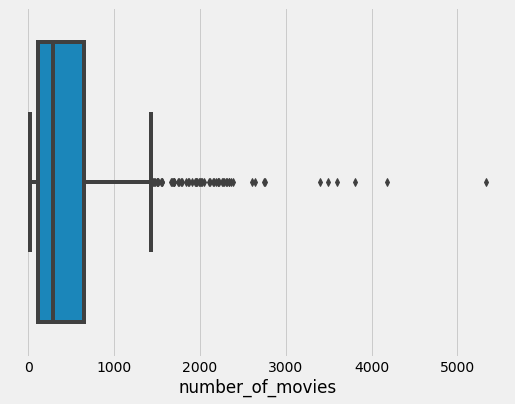

In [55]:
fig = plt.figure(figsize=(8, 6))
sns.boxplot(x=number_movies["number_of_movies"])

As we don't have the true time when a movie was watched it's hard to generate good recommendations. I mean if we had the time we would cut the last n-days to the test set and try to predict recommendations based on other days. We would simulate the real situation by splitting the initial data in such way.

So I suggest to get rid of users which have less than 100 movies watched, after that to cut 50 movies for test and the rest for train.

In [56]:
final_users = number_movies[number_movies["number_of_movies"] >= 100]
print(final_users.shape)
final_users.head()

(628, 2)


,userId,number_of_movies
0,22,133
2,77,100
3,295,324
4,377,199
6,572,1325


In [57]:
final_ratings = special_ratings_data[special_ratings_data["userId"].isin(final_users["userId"])]
print(final_ratings.shape)
final_ratings.head()

(389572, 4)


,userId,movieId,rating,date
2302,22,1,3.0,2001-07-09
2303,22,6,5.0,2001-07-09
2304,22,16,5.0,2001-07-09
2305,22,47,4.0,2001-07-09
2306,22,50,4.0,2001-07-09


## Global train-test

In [58]:
# forming test dataset
for_test = []
for user in final_ratings["userId"].unique():
    for_test.append(final_ratings[final_ratings["userId"] == user].iloc[-50:])
global_test = pd.concat(for_test, ignore_index=True)
print(global_test.shape)
global_test.head()

(31400, 4)


,userId,movieId,rating,date
0,22,2617,4.0,2001-07-09
1,22,2640,4.0,2001-07-09
2,22,2641,3.0,2001-07-09
3,22,2642,3.0,2001-07-09
4,22,2643,2.0,2001-07-09


In [59]:
global_train = pd.merge(final_ratings,global_test, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
print(global_train.shape)
global_train.head()

(358172, 4)


,userId,movieId,rating,date
0,22,1,3.0,2001-07-09
1,22,6,5.0,2001-07-09
2,22,16,5.0,2001-07-09
3,22,47,4.0,2001-07-09
4,22,50,4.0,2001-07-09


We will make recoms only for warm users. To get more information about cold-start problem in recommender systems read [this](https://www.quora.com/What-are-cold-start-and-warm-start-in-recommendation-systems)

In [60]:
# let's check if all users from test dataset are in train
all(global_test["userId"].isin(global_train["userId"]))

True

## Train-test for implisit ALS

**Let's leave 20 samples from each user to test dataset.**


In [61]:
# forming test dataset
for_test_als = []
for user in global_train["userId"].unique():
    for_test_als.append(global_train[global_train["userId"] == user].iloc[-20:])
als_test = pd.concat(for_test_als, ignore_index=True)
print(als_test.shape)
als_test.head()

(12560, 4)


,userId,movieId,rating,date
0,22,2000,4.0,2001-07-09
1,22,2001,5.0,2001-07-09
2,22,2002,3.0,2001-07-09
3,22,2028,3.0,2001-07-09
4,22,2058,3.0,2001-07-09


In [62]:
als_train = pd.merge(global_train,als_test, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
print(als_train.shape)
als_train.head()

(345612, 4)


,userId,movieId,rating,date
0,22,1,3.0,2001-07-09
1,22,6,5.0,2001-07-09
2,22,16,5.0,2001-07-09
3,22,47,4.0,2001-07-09
4,22,50,4.0,2001-07-09


In [63]:
# let's check if all users from test dataset are in train
all(als_test["userId"].isin(als_train["userId"]))

True

# 5 Creating a model

## 5.1 First-level model 

We need to convert our iteraction dataset to csr_matrix to feed it to implicit model. When generating csr_matrix we'll lose our true id of items and users. Insted of them we'll have digits arranged in order. So we need to create the dataset with true id and corresponding digits.

**One more moment**: in that notebook I want to use implicit feedback between user and item. So I won't use rating while generating user-item matrix

One can read about implicit and explicit feedback [here](https://medium.com/analytics-vidhya/recommender-systems-explicit-feedback-implicit-feedback-and-hybrid-feedback-ddd1b2cdb3b)

In [64]:
movie_ids = final_ratings[["movieId"]].drop_duplicates(ignore_index=True)
movie_ids.reset_index(inplace=True)
movie_ids.rename(columns={"index": "encoded_movie_id"}, inplace=True)
print(movie_ids.shape)
movie_ids.head()

(16011, 2)


,encoded_movie_id,movieId
0,0,1
1,1,6
2,2,16
3,3,47
4,4,50


In [65]:
user_ids = final_ratings[["userId"]].drop_duplicates(ignore_index=True)
user_ids.reset_index(inplace=True)
user_ids.rename(columns={"index": "encoded_user_id"}, inplace=True)
print(user_ids.shape)
user_ids.head()

(628, 2)


,encoded_user_id,userId
0,0,22
1,1,77
2,2,295
3,3,377
4,4,572


In [66]:
interactions = final_ratings[["userId", "movieId"]]
interactions["encoded_user_id"] = interactions["userId"].map(user_ids.set_index('userId')["encoded_user_id"])
interactions["encoded_movie_id"] = interactions["movieId"].map(movie_ids.set_index('movieId')["encoded_movie_id"])
interactions.head()

,userId,movieId,encoded_user_id,encoded_movie_id
2302,22,1,0,0
2303,22,6,0,1
2304,22,16,0,2
2305,22,47,0,3
2306,22,50,0,4


In [67]:
print("The number of unique movies -", len(interactions['encoded_movie_id'].unique()), "\n", "The number of unique user-", len(interactions['encoded_user_id'].unique()),\
"\n", "The number of iteractions -",len(interactions))

The number of unique movies - 16011 
 The number of unique user- 628 
 The number of iteractions - 389572


In [68]:
# we need to convert our iteraction dataset to csr_matrix to feed it to implicit model
from scipy.sparse import csr_matrix

# this coef. scales the the result of interaction to emphasize it
alpha = 40

item_user_matrix = csr_matrix(([alpha]*len(interactions['encoded_movie_id']), (interactions['encoded_user_id'], interactions['encoded_movie_id'])))
item_user_matrix

<628x16011 sparse matrix of type '<class 'numpy.int64'>'
	with 389572 stored elements in Compressed Sparse Row format>

As we see the size of matrix is the same as the unique number of user(row) and the unique number of movies(column).

In [69]:
!pip install implicit==0.5.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 33.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: implicit
    Found existing installation: implicit 0.4.4
    Uninstalling implicit-0.4.4:
      Successfully uninstalled implicit-0.4.4


In [70]:
from implicit.gpu.als import AlternatingLeastSquares

In [71]:
# initializing implicit ALS
als_model = AlternatingLeastSquares(iterations=150 ,random_state=0)

In [72]:
%%time
als_model.fit(item_user_matrix)

  0%|          | 0/150 [00:00<?, ?it/s]

Warning NaN Detected in row 15585 of 16011
Warning NaN Detected in row 2322 of 16011
Warning NaN Detected in row 447 of 16011
Warning NaN Detected in row 1094 of 16011
Warning NaN Detected in row 2237 of 16011
Warning NaN Detected in row 31 of 16011
Warning NaN Detected in row 2117 of 16011
Warning NaN Detected in row 3916 of 16011
Warning NaN Detected in row 1892 of 16011
Warning NaN Detected in row 2584 of 16011
Warning NaN Detected in row 2644 of 16011
Warning NaN Detected in row 1725 of 16011
Warning NaN Detected in row 10 of 16011
Warning NaN Detected in row 2075 of 16011
Warning NaN Detected in row 1522 of 16011
Warning NaN Detected in row 2183 of 16011
Warning NaN Detected in row 2639 of 16011
Warning NaN Detected in row 424 of 16011
Warning NaN Detected in row 3513 of 16011
Warning NaN Detected in row 4125 of 16011
Warning NaN Detected in row 10619 of 16011
Warning NaN Detected in row 731 of 16011
Warning NaN Detected in row 14934 of 16011
Warning NaN Detected in row 2316 of 16

In [73]:
%%time
num_recoms = 200
all_recoms = pd.DataFrame()
for i in tqdm( range(item_user_matrix.shape[0])):
# we don't filter already liked items as the second-level model needs to see some examples of positive interaction
  recoms = als_model.recommend(i, item_user_matrix[i], N=num_recoms, filter_already_liked_items=False)
  for j in range(num_recoms):
    all_recoms = all_recoms.append({"userId": interactions.copy()["userId"].unique()[i], "rewritten_movie_id": int(recoms[0][j]), "score": recoms[1][j]}, ignore_index=True)
    

all_recoms["rank"] = all_recoms.groupby("userId").cumcount() + 1
all_recoms["movieId"] = all_recoms["rewritten_movie_id"].map(movie_ids.set_index("encoded_movie_id")["movieId"])

all_recoms["userId"] = all_recoms["userId"].astype(int)


100%|██████████| 628/628 [37:23<00:00,  3.57s/it]

CPU times: user 18min 32s, sys: 18min 42s, total: 37min 15s
Wall time: 37min 23s


In [145]:
# try:
#   with open(path + 'first_level_recoms.pickle', 'rb') as f:
#     all_recoms = pickle.load(f)
# except:
#   with open(path + "first_level_recoms.pickle", 'wb') as f:
#     pickle.dump(all_recoms, f)
#   with open(path + 'first_level_recoms.pickle', 'rb') as f:
#     all_recoms = pickle.load(f)

In [75]:
all_recoms.drop("rewritten_movie_id", axis=1, inplace=True)
# all_recoms.rename(columns={"user_id": "userId", "movie_id": "movieId"}, inplace=True)


print(all_recoms.shape)
all_recoms.head()

(125600, 4)


,userId,score,rank,movieId
0,22,2819.250000,1,27919
1,22,354.119385,2,6735
2,22,166.069397,3,31337
3,22,138.336212,4,70093
4,22,128.849686,5,3149


## 5.2 Second-level model

The task of second-level model is binary classification. 
"1"(positive) - everything from recommender list that a user interacted with.
"0"(negative) - everything from recommender list that a user didn't interact with.





### Forming positive and negative interactions

In [78]:
pos = all_recoms.merge(als_test,
                        on=['userId', 'movieId'],
                        how='inner')

pos['target'] = 1
print(pos.shape)
pos.head()

(388, 7)


,userId,score,rank,movieId,rating,date,target
0,77,1.093422,146,1274,5.0,2012-07-04,1
1,77,0.931398,199,1258,4.0,2012-07-04,1
2,295,1.036945,162,1242,4.0,1997-05-18,1
3,377,1.017951,191,1073,5.0,1997-05-24,1
4,1668,0.985295,166,1270,5.0,1999-12-23,1


In [79]:
neg = all_recoms.set_index(['userId', 'movieId'])\
        .join(als_test.set_index(['userId', 'movieId']))

neg['target'] = 0

# there are too many samples of negative examples, so we have to apply sampling
neg = neg.sample(frac=0.015)
neg.reset_index(inplace=True)

print(neg.shape)
neg.head()

(1884, 7)


,userId,movieId,score,rank,rating,date,target
0,2226,71755,2.701978,59,NaN,NaN,0
1,122827,4836,1.505762,130,NaN,NaN,0
2,98728,476,1.260940,193,NaN,NaN,0
3,17882,100038,3.945853,96,NaN,NaN,0
4,6636,79274,0.001501,145,NaN,NaN,0


### Forming train and test for second-level model

In [80]:
# we'll have numpy.ndarray as output
ctb_train_users, ctb_test_users = train_test_split(als_test['userId'].unique(),
                                                  random_state=2,
                                                  test_size=0.2)

# for model not to overfit
ctb_train_users, ctb_eval_users = train_test_split(ctb_train_users,
                                                  random_state=2,
                                                  test_size=0.1)
print("train -", ctb_train_users.shape, "test -", ctb_test_users.shape, "eval -", ctb_eval_users.shape)

train - (451,) test - (126,) eval - (51,)


In [81]:
# forming train, test and eval dataframes
select_col = ['userId', 'movieId', 'rank', 'target']

# Catboost train
ctb_train = shuffle(
    pd.concat([
        pos[pos['userId'].isin(ctb_train_users)],
        neg[neg['userId'].isin(ctb_train_users)]
])[select_col]
)

# Catboost test
ctb_test = shuffle(
    pd.concat([
        pos[pos['userId'].isin(ctb_test_users)],
        neg[neg['userId'].isin(ctb_test_users)]
])[select_col]
)

# for early stopping
ctb_eval = shuffle(
    pd.concat([
        pos[pos['userId'].isin(ctb_eval_users)],
        neg[neg['userId'].isin(ctb_eval_users)]
])[select_col]
)

Let's have a look at the balance of classes

In [82]:
ctb_train['target'].value_counts(normalize=True)

0    0.828818
1    0.171182
Name: target, dtype: float64

In [83]:
ctb_test['target'].value_counts(normalize=True)

0    0.842451
1    0.157549
Name: target, dtype: float64

### Adding features

In [84]:
movies_data_concat.head()

,movieId,title,genres,year_shot,genres_list,period_0,period_1,period_2,period_3,period_4,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,"[Adventure, Animation, Children, Comedy, Fantasy]",1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,"[Adventure, Children, Fantasy]",1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,"[Comedy, Romance]",1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,"[Comedy, Drama, Romance]",1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,1995,[Comedy],1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [131]:
col = list(movies_data_concat.columns)
needed_col = [element for element in col if element not in ["title", "year_shot", "genres", "genres_list"]]

train_feat = ctb_train.merge(movies_data_concat[needed_col], on=['movieId'],  how='left')
test_feat = ctb_test.merge(movies_data_concat[needed_col], on=['movieId'],  how='left')
eval_feat = ctb_eval.merge(movies_data_concat[needed_col], on=['movieId'],  how='left')

print(train_feat.shape)
print(test_feat.shape)
print(eval_feat.shape)

train_feat.head(2)
                                  

(1624, 35)
(457, 35)
(191, 35)


,userId,movieId,rank,target,period_0,period_1,period_2,period_3,period_4,period_5,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,98057,113767,104,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9207,77752,137,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
test_feat.head(2)

,userId,movieId,rank,target,period_0,period_1,period_2,period_3,period_4,period_5,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,13892,107344,78,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,77095,106785,184,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [87]:
eval_feat.head(2)

,userId,movieId,rank,target,period_0,period_1,period_2,period_3,period_4,period_5,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,113495,74099,76,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,50011,235,195,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Splitting to X and y 

In [88]:
drop_col = ['userId', 'movieId']
target_col = ['target']
cat_col = needed_col.remove("movieId")

In [89]:
X_train, y_train = train_feat.drop(drop_col + target_col, axis=1), train_feat[target_col]
X_test, y_test = test_feat.drop(drop_col + target_col, axis=1), test_feat['target']
X_val, y_val = eval_feat.drop(drop_col + target_col, axis=1), eval_feat[target_col]

print("X_train -" ,X_train.shape, "y_train -", y_train.shape,"\n", "X_test -", X_test.shape, "y_test -", y_test.shape, "\n","X_val -", X_val.shape, "y_val -",  y_val.shape)

X_train - (1624, 32) y_train - (1624, 1) 
 X_test - (457, 32) y_test - (457,) 
 X_val - (191, 32) y_val - (191, 1)


In [90]:
X_train.head(2)

,rank,period_0,period_1,period_2,period_3,period_4,period_5,period_6,period_7,period_8,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,104,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,137,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Fitting the model

In that notebook I just demonstrate a baseline and the hypoparameters of Catboost are not the most effective

In [91]:
from catboost import CatBoostClassifier

# параметры для обучения
best_params = {
  'max_depth': 5,
  'n_estimators': 2000,
  'learning_rate': 0.1,
  'thread_count': 20,
  'random_state': 0,
  'verbose': 200,
}

ctb_model = CatBoostClassifier(**best_params)

In [92]:
ctb_model.fit(X_train,
              y_train,
              eval_set=(X_val, y_val),
              early_stopping_rounds=200,
              cat_features=cat_col,
              plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TBB Warning: The number of workers is currently limited to 1. The request for 19 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



0:	learn: 0.5896931	test: 0.6005595	best: 0.6005595 (0)	total: 51.5ms	remaining: 1m 42s
200:	learn: 0.1310401	test: 0.2073445	best: 0.2064823 (191)	total: 253ms	remaining: 2.26s
400:	learn: 0.0845938	test: 0.2129013	best: 0.2047207 (244)	total: 457ms	remaining: 1.82s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.2047206798
bestIteration = 244

Shrink model to first 245 iterations.


### Estimating the model

We'll estimate the model with just the metrics for classification tasks. 
[This](https://chaitanyabelhekar.medium.com/recommender-system-metrics-clearly-explained-1f2ba6690216) is a good article about some metrics used in recommender systems


In [93]:
y_pred = ctb_model.predict(X_test)

In [94]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       385
           1       0.63      0.60      0.61        72

    accuracy                           0.88       457
   macro avg       0.78      0.77      0.77       457
weighted avg       0.88      0.88      0.88       457



We see that the model is very bad in detecting the regularity for positive samples. 

Several thoughts how to improve that:
* increase the proportion of positive sampels / reduce the proportion of negative;
* optimizing hypoparameters of the model.

# 6 Estimating models on the global test with recommendation metrics

In [95]:
# for computing precision@k, recall@k and MAP@k
def metrics(df_true, df_pred, top_N, cols,  rank_col='rank'):
    result = {}
    test_recs = df_true.set_index([cols[0], cols[1]]).join(df_pred.set_index([cols[0], cols[1]]))
    test_recs = test_recs.sort_values(by=[cols[0], rank_col])

    test_recs['users_item_count'] = test_recs.groupby(level=cols[0])[rank_col].transform(np.size)
    test_recs['reciprocal_rank'] = (1 / test_recs[rank_col]).fillna(0)
    test_recs['cumulative_rank'] = test_recs.groupby(level=cols[0]).cumcount() + 1
    test_recs['cumulative_rank'] = test_recs['cumulative_rank'] / test_recs[rank_col]

    users_count = test_recs.index.get_level_values(cols[0]).nunique()
    for k in range(1, top_N + 1):
        hit_k = f'hit@{k}'
        test_recs[hit_k] = test_recs[rank_col] <= k
        result[f'Precision@{k}'] = (test_recs[hit_k] / k).sum() / users_count
        result[f'Recall@{k}'] = (test_recs[hit_k] / test_recs['users_item_count']).sum() / users_count

    result[f'MAP@{top_N}'] = (test_recs["cumulative_rank"] / test_recs["users_item_count"]).sum() / users_count
    result[f'MRR'] = test_recs.groupby(level=cols[0])['reciprocal_rank'].max().mean()
    return pd.Series(result)

## 6.1 First-level model

In [96]:
# we need to add data from als_tes to the model thus our recoms might change. For this we need to create new sparse_matrix
als_test_interactions = als_test[["userId", "movieId"]]
als_test_interactions["encoded_user_id"] = als_test_interactions["userId"].map(user_ids.set_index('userId')["encoded_user_id"])
als_test_interactions["encoded_movie_id"] = als_test_interactions["movieId"].map(movie_ids.set_index('movieId')["encoded_movie_id"])

print(als_test_interactions.shape)
als_test_interactions.head()

(12560, 4)


,userId,movieId,encoded_user_id,encoded_movie_id
0,22,2000,0,63
1,22,2001,0,64
2,22,2002,0,65
3,22,2028,0,66
4,22,2058,0,67


In [97]:
# additional sparse matrix
add_item_user_matrix = csr_matrix(([alpha]*len(als_test_interactions['encoded_movie_id']), (als_test_interactions['encoded_user_id'], als_test_interactions['encoded_movie_id'])))
add_item_user_matrix

<628x16007 sparse matrix of type '<class 'numpy.int64'>'
	with 12560 stored elements in Compressed Sparse Row format>

In [101]:
from tqdm.notebook import tqdm

In [104]:
%%time
first_level_recoms = pd.DataFrame()
for i in tqdm(range(item_user_matrix.shape[0])):
# we don't filter already liked items as the second-level model needs to see some examples of positive interaction
  new_recoms = als_model.recommend(i, add_item_user_matrix[i], N=num_recoms, filter_already_liked_items=False, recalculate_user=True)
  for j in range(num_recoms):
    first_level_recoms = first_level_recoms.append({"userId": interactions.copy()["userId"].unique()[i], "rewritten_movie_id": int(recoms[0][j]), "score": new_recoms[1][j]}, ignore_index=True)
    

first_level_recoms["rank"] = first_level_recoms.groupby("userId").cumcount() + 1
first_level_recoms["movieId"] = first_level_recoms["rewritten_movie_id"].map(movie_ids.set_index("encoded_movie_id")["movieId"])

first_level_recoms["userId"] = first_level_recoms["userId"].astype(int)

  0%|          | 0/628 [00:00<?, ?it/s]

Warning NaN Detected in row 0 of 1
Warning NaN Detected in row 0 of 1
Warning NaN Detected in row 0 of 1
Warning NaN Detected in row 0 of 1
Warning NaN Detected in row 0 of 1
Warning NaN Detected in row 0 of 1
Warning NaN Detected in row 0 of 1
Warning NaN Detected in row 0 of 1
Warning NaN Detected in row 0 of 1
Warning NaN Detected in row 0 of 1
Warning NaN Detected in row 0 of 1
Warning NaN Detected in row 0 of 1
Warning NaN Detected in row 0 of 1
Warning NaN Detected in row 0 of 1
Warning NaN Detected in row 0 of 1
Warning NaN Detected in row 0 of 1
Warning NaN Detected in row 0 of 1
Warning NaN Detected in row 0 of 1
Warning NaN Detected in row 0 of 1
Warning NaN Detected in row 0 of 1
Warning NaN Detected in row 0 of 1
Warning NaN Detected in row 0 of 1
Warning NaN Detected in row 0 of 1
Warning NaN Detected in row 0 of 1
Warning NaN Detected in row 0 of 1
Warning NaN Detected in row 0 of 1
Warning NaN Detected in row 0 of 1
Warning NaN Detected in row 0 of 1
Warning NaN Detected

In [147]:
# try:
#   with open(path + 'first_level.pickle', 'rb') as f:
#     new_recoms = pickle.load(f)
# except:
#   with open(path + "first_level.pickle", 'wb') as f:
#     pickle.dump(new_recoms, f)
#   with open(path + 'first_level.pickle', 'rb') as f:
#     new_recoms = pickle.load(f)

In [146]:
# first_level_recoms.drop("rewritten_movie_id", axis=1, inplace=True)

In [114]:
als_metrics = metrics(global_test[['userId', 'movieId']],
                              first_level_recoms,
                              cols = ["userId", "movieId"], 
                              top_N=10)
als_metrics

Precision@1     0.000000
Recall@1        0.000000
Precision@2     0.000000
Recall@2        0.000000
Precision@3     0.000000
Recall@3        0.000000
Precision@4     0.000398
Recall@4        0.000032
Precision@5     0.000637
Recall@5        0.000064
Precision@6     0.000796
Recall@6        0.000096
Precision@7     0.000682
Recall@7        0.000096
Precision@8     0.000796
Recall@8        0.000127
Precision@9     0.000708
Recall@9        0.000127
Precision@10    0.000796
Recall@10       0.000159
MAP@10          0.000084
MRR             0.003332
dtype: float64

The results are not good at all)

## 6.2 Second-level model

In [112]:
ctb_prediction = first_level_recoms.copy()

In [121]:
ctb_prediction.head()

,userId,score,rank,movieId
0,22,253.662369,1,4199
1,22,126.441666,2,27919
2,22,117.286446,3,4551
3,22,93.112762,4,70093
4,22,89.436577,5,79588


In [132]:
recoms_feat = ctb_prediction.merge(movies_data_concat[needed_col], on=['movieId'],  how='left')
recoms_feat.head()

,userId,score,rank,movieId,period_0,period_1,period_2,period_3,period_4,period_5,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,22,253.662369,1,4199,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,22,126.441666,2,27919,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,22,117.286446,3,4551,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,22,93.112762,4,70093,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,22,89.436577,5,79588,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [133]:
# catboost predict_proba
cat_preds = ctb_model.predict_proba(recoms_feat.drop(drop_col, axis=1, errors='ignore'))

ctb_prediction['ctb_pred'] = cat_preds[:, 1]
ctb_prediction.head(3)

ctb_prediction.sort_values(
    by=['userId'], ascending=[True]).head(10)


,userId,score,rank,movieId,ctb_pred
0,22,253.662369,1,4199,0.002840
127,22,2.467811,128,5123,0.021962
128,22,2.438329,129,8850,0.075226
129,22,2.437652,130,3800,0.169422
130,22,2.418442,131,111529,0.002764
131,22,2.417786,132,94661,0.044935
132,22,2.406785,133,39474,0.006716
133,22,2.402179,134,101104,0.019526
134,22,2.380926,135,31547,0.043452
135,22,2.324052,136,39408,0.115712


**Make ultimate rank of two-level model**

In [134]:
ctb_prediction = ctb_prediction.sort_values(
    by=['userId', 'ctb_pred'], ascending=[True, False])
ctb_prediction['rank_ctb'] = ctb_prediction.groupby('userId').cumcount() + 1

In [136]:
ctb_prediction.head()

,userId,score,rank,movieId,ctb_pred,rank_ctb
195,22,1.453695,196,4985,0.981164,1
179,22,1.597646,180,2051,0.936381,2
196,22,1.435593,197,5286,0.861142,3
158,22,1.907081,159,828,0.694808,4
194,22,1.455785,195,67168,0.694366,5


**We see that the ranks of catboost seems completly reverse in comparison to ALS implicit**

In [142]:
model_2step_metrics = metrics(global_test[['userId', 'movieId']],
                                       ctb_prediction, 
                                       top_N=10,
                                       cols = ["userId", "movieId"],
                                       rank_col='rank_ctb')
model_2step_metrics

Precision@1     0.000000
Recall@1        0.000000
Precision@2     0.000000
Recall@2        0.000000
Precision@3     0.000000
Recall@3        0.000000
Precision@4     0.000796
Recall@4        0.000064
Precision@5     0.000637
Recall@5        0.000064
Precision@6     0.000796
Recall@6        0.000096
Precision@7     0.000682
Recall@7        0.000096
Precision@8     0.000796
Recall@8        0.000127
Precision@9     0.000708
Recall@9        0.000127
Precision@10    0.000637
Recall@10       0.000127
MAP@10          0.000083
MRR             0.003175
dtype: float64

In [143]:
df_metrics = pd.concat([
    pd.DataFrame(als_metrics).transpose(),
    pd.DataFrame(model_2step_metrics).transpose()
])

df_metrics.index = ['als_implicit', 'model_2step']

df_metrics

,Precision@1,Recall@1,Precision@2,Recall@2,Precision@3,Recall@3,Precision@4,Recall@4,Precision@5,Recall@5,...,Precision@7,Recall@7,Precision@8,Recall@8,Precision@9,Recall@9,Precision@10,Recall@10,MAP@10,MRR
als_implicit,0.0,0.0,0.0,0.0,0.0,0.0,0.000398,0.000032,0.000637,0.000064,...,0.000682,0.000096,0.000796,0.000127,0.000708,0.000127,0.000796,0.000159,0.000084,0.003332
model_2step,0.0,0.0,0.0,0.0,0.0,0.0,0.000796,0.000064,0.000637,0.000064,...,0.000682,0.000096,0.000796,0.000127,0.000708,0.000127,0.000637,0.000127,0.000083,0.003175


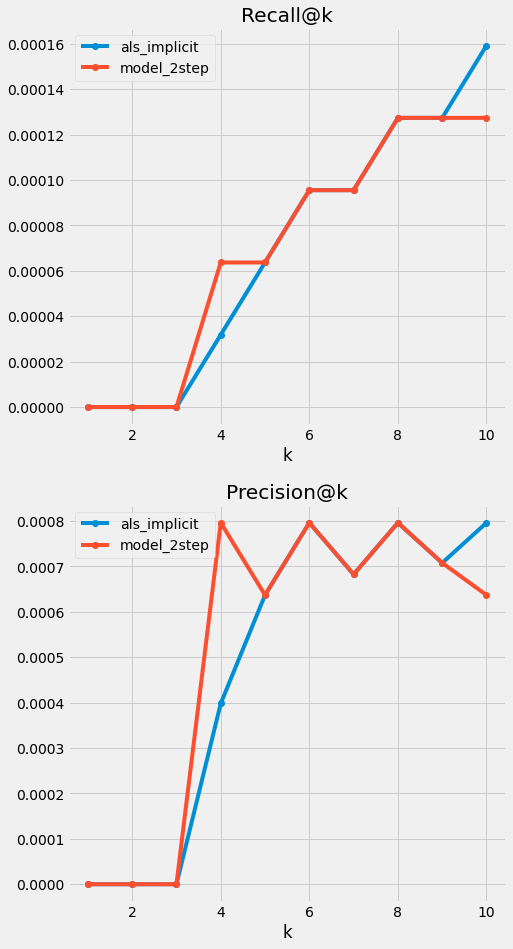

In [144]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(7, 15))

for indx, metric in enumerate([f'Recall@', f'Precision@']):
    for model in df_metrics.index:
        axes[indx].plot(range(1, 11), 
                        df_metrics.loc[model][[metric+f'{k}' for k in range(1, 11)]].values,
                        label=model, marker='o')
        axes[indx].legend()
        axes[indx].set_title(f'{metric}k')
        axes[indx].set_xlabel('k')

# 7 Conclusion

In that example it's not clear that re-ranking with gradient boosting makes recommendations better. The value of metrics is too small!

For trying to improve our results and metrics I suggest following:
* find the best parameters for firsl-level model;
* find the best parameters for second-level model;
* use more data;
* increase the proportion of positive samples / dicrease the proportion of negative.